Import necessary libraries

In [1]:
import pandas as pd
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt

Load dataset and pre-trained embeddings

In [2]:
df = pd.read_csv('/kaggle/input/no-index-news/preprocessed_data (2).csv')
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
df["InputIDs"] = df["Paragraph"].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=256, padding="max_length")
)



config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [3]:
inputs = torch.tensor(df["InputIDs"].values.tolist())
labels = torch.tensor(df["Topic"].values.tolist())

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs, labels, test_size=len(inputs) // 10, random_state=42
)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_inputs, train_labels, test_size=len(inputs) // 10, random_state=42
)

In [4]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        padding_idx,
        hidden_dim,
        num_layers,
        num_classes,
        dropout=0.5,
    ):
        super(TextCNN, self).__init__()
        #1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        #2. convolutional layers
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3)
        #3. final, fully-connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)
        #4.dropout and relu layers
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        #5.pooling layers
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        x = self.embedding(x)  # Embedding layer
        # Permute dimensions for CNN before conv layer
        x = x.permute(0, 2, 1)
        # Dropout
        x = self.dropout(x)
        # Apply the convolutional layer
        x = self.conv1(x)
        # Apply ReLU activation
        x = self.relu(x)
        # Max pooling
        x = self.pool(x)
        # Flatten for dense layers
        x = x.flatten(start_dim=1)
        # Apply the final fully connected layer and activation
        x = self.fc(x)
        return x

model = TextCNN(
    vocab_size = tokenizer.vocab_size,
    embedding_dim = 256,
    padding_idx = tokenizer.pad_token_id,
    hidden_dim = 256,
    num_layers = 5,
    num_classes = 15,
    dropout = 0.5
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_labels)
test_dataset = torch.utils.data.TensorDataset(test_inputs, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)


CrossEntropyLoss()

In [6]:
train_loss_history = []
val_loss_history = []

In [7]:
for epoch in range(15):
    model.train()
    running_loss = 0.0
    
    # Vòng lặp huấn luyện cho tập train
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Tính loss trung bình cho tập train và lưu lại
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

    # Đánh giá trên tập validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Tính loss trung bình cho tập validation và lưu lại
    val_loss = val_running_loss / len(val_loader)
    val_loss_history.append(val_loss)
    
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1, Train Loss: 1.4285
Validation Loss: 0.9197, Validation Accuracy: 72.80%
Epoch 2, Train Loss: 0.5542
Validation Loss: 0.7982, Validation Accuracy: 76.17%
Epoch 3, Train Loss: 0.1933
Validation Loss: 0.8197, Validation Accuracy: 77.47%
Epoch 4, Train Loss: 0.0674
Validation Loss: 0.8136, Validation Accuracy: 77.63%
Epoch 5, Train Loss: 0.0469
Validation Loss: 0.7691, Validation Accuracy: 79.90%
Epoch 6, Train Loss: 0.0459
Validation Loss: 0.8213, Validation Accuracy: 79.60%
Epoch 7, Train Loss: 0.0548
Validation Loss: 0.9860, Validation Accuracy: 78.13%
Epoch 8, Train Loss: 0.0773
Validation Loss: 0.9746, Validation Accuracy: 78.97%
Epoch 9, Train Loss: 0.0712
Validation Loss: 1.0059, Validation Accuracy: 79.23%
Epoch 10, Train Loss: 0.0501
Validation Loss: 1.0567, Validation Accuracy: 78.30%
Epoch 11, Train Loss: 0.0529
Validation Loss: 0.9982, Validation Accuracy: 80.47%
Epoch 12, Train Loss: 0.0511
Validation Loss: 1.1435, Validation Accuracy: 78.30%
Epoch 13, Train Loss: 0.0

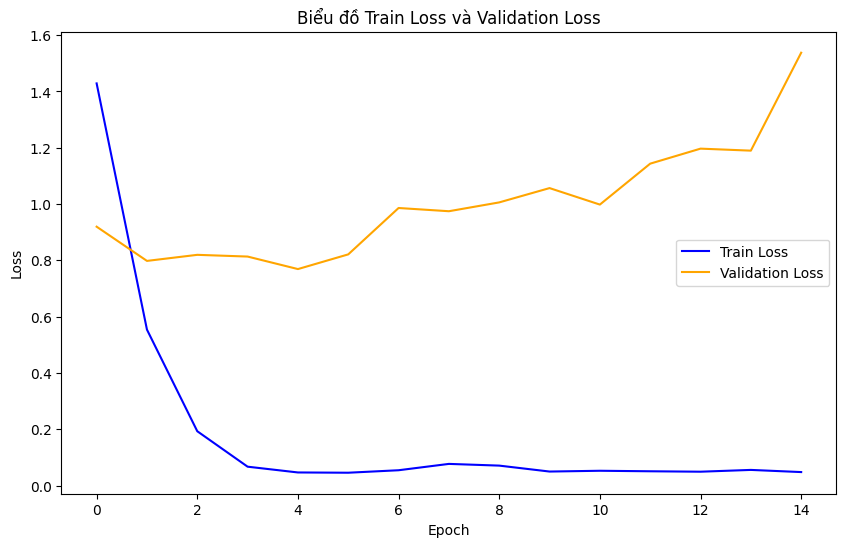

In [8]:


plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biểu đồ Train Loss và Validation Loss')
plt.legend()
plt.show()
